# Comparison of all methods for the Bagging case (with cycles)

In this notebook we are comparing the performance of our proposed method Complexity Driven Bagging and the version of the state of the art: Standard Bagging and Mixed Bagging, which implies two options: Grouped Mixed Bagging and Incremental Bagging.

Note that the **number of models** works differently in the three types of methods. In particular,

* Standard Bagging: as always
* Mixed Bagging: The proposal of Mixed bagging consists of choosing a number of models (number of bootstrap samples) and according to that number, they split the complexity space. You cannot obtain intermediate results because the complexity space is divided according to that total number of models. Then, there are different parameters concerning how to split the complexity space. They test all of them and return the value of the best parameter combination. Note that, among the parameters they are testing, they always consider the "neutral" case which is exactly standard bagging.
* CDB: In our proposal, the user should decide the number of splits. This number determines the length of every complete cycle (we need to complete each cycle to cover the complexity space from the easiest case to the hardest case). The user should also decide the number of cycles which is the number of times a whole cycle is going to be performed. In our case, we can show results at the end of each cycle.

Since we have already performed a first analysis concerning the range of parameters of our method. We are going to compare our proposal to SOTA in **two different scenarios**:

* Considering all the cycles 
* Considering only the cycles with significant differences



The **range of our parameters** (based on the analyses we made on R) are:

* alpha: [2, 4, 6, 8, 10]
* split: [2, 4, 6, 8, 10, 12, 14]
* Number of cycles/Number of models: it is related with parameter split

We have to simplify these choices. Make the range of alpha and split smaller and recommend the number of cycles associate with each split.
Number of models in each cycle is split*2+1.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

os.chdir("..")
root_path = os.getcwd()

In [3]:
## We load results from SOTA
path_csv = os.chdir(root_path+'/Results_StandardBagging')
df_standard = pd.read_csv('AllResults_StandardBagging.csv') ## all n_ensembles

# Best results for standard bagging
best_param_standard = df_standard.loc[df_standard.groupby(["Dataset"])["accuracy_mean"].idxmax()]


path_csv = os.chdir(root_path+'/MixedBagging/Adapted_results')
df_mixed = pd.read_csv('AllResults_MixedBagging.csv') # all n_trees

# Best result per dataset and complexity measure
best_param_mixed = df_mixed.loc[df_mixed.groupby(["Dataset", "model"])["accuracy_mean"].idxmax()]



In [4]:
# Our results

## We begin by loading the CDB results and the results regarding the maximum number of cycles
path_csv = os.chdir(root_path+'/Results_general_algorithm_cycles')
df_cdb = pd.read_csv('TotalAggregatedResults_ParameterConfiguration_CDB.csv')
#df_cbd_info_cycles = pd.read_csv('CDB_cycles_ParametersComboAlphaSplit_dif_no_signif_cycles_mean_median_std_num_models.csv')
# max_num_cycles, max_num_models son las variables que indican el número máximo de modelos/ciclos a tener en cuenta
# si no queremos tener en cuenta aquellos para los que ya no hay diferencias significativas

# Valores que escogemos para alpha y split con el estudio de R CDB_cycles_AnalysisOfParameters
# Domain for split: [2, 4, 6, 8, 10, 12, 14]
# Domain for alpha: [2, 4, 6, 8, 10]
alpha_domain= [2, 4, 6, 8, 10]
split_domain = [2, 4, 6, 8, 10, 12, 14]

# For every dataset, we want to obtain, for every complexity measure, the accuracy of the best combination
# of alpha, split and number of cycles/ensemble
# We first filter the df following the final domain for split and alpha
df_cdb_f = df_cdb[df_cdb['alpha'].isin(alpha_domain) & df_cdb['split'].isin(split_domain)]

# Best result per dataset and complexity measure
best_param_cdb = df_cdb_f.loc[df_cdb_f.groupby(["Dataset", "weights"])["accuracy_mean"].idxmax()]


# Info of significant differences
df_signif = pd.read_csv('CDB_cycles_ParametersComboAlphaSplit_dif_no_signif_cycles_mean_median_std_num_models.csv')

## Vamos a añadir a df_cdb_f la columna del máximo número de modelos
# Separamos la columna valores_combo en alpha y split
df_signif[['alpha', 'split']] = (
    df_signif['valores_combo']
    .str.extract(r'alpha(\d+)-split(\d+)')  # Extrae los números después de 'alpha' y 'split'
    .astype(int)  # Convierte a entero para asegurar el mismo tipo en ambos datasets
)


# Merge entre df_cdb_f y df_signif
df_cdb_f['alpha'] = df_cdb_f['alpha'].astype(str)
df_cdb_f['split'] = df_cdb_f['split'].astype(str)
df_signif['alpha'] = df_signif['alpha'].astype(str)
df_signif['split'] = df_signif['split'].astype(str)
df_cdb_m = pd.merge(
    df_cdb_f,
    df_signif[['alpha', 'split', 'max_num_models']],  # Solo necesitamos estas columnas tras la separación
    on=['alpha', 'split'],
    how='left')

# Filtrar los valores donde n_ensemble es menor o igual al máximo permitido
df_cdb_signif = df_cdb_m[df_cdb_m['n_ensemble'] <= df_cdb_m['max_num_models']]


# Best result per dataset and complexity measure only with significant differences
best_param_cdb_signif = df_cdb_signif.loc[df_cdb_signif.groupby(["Dataset", "weights"])["accuracy_mean"].idxmax()]



/tmp/ipykernel_14923/3079955332.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cdb_f['alpha'] = df_cdb_f['alpha'].astype(str)
/tmp/ipykernel_14923/3079955332.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cdb_f['split'] = df_cdb_f['split'].astype(str)


#### Functions to obtain results

In [5]:
#############################################################################################
#############                         COMPARISON WTL                            #############
#############################################################################################
# lo ponemos junto en un df y comparamos con WTL el mejor resultado de cada uno


def Results_format_for_WTL(df_cdb_best, df_mixed_best, df_standard_best):

    table_comparison = pd.DataFrame(columns=['Dataset', 'Standard_Bag_mean', 'Standard_Bag_std','Standard_Bag_n_ensemble'])
    table_comparison['Dataset'] = df_standard_best['Dataset']
    table_comparison['Standard_Bag_mean'] = df_standard_best["accuracy_mean"]
    table_comparison['Standard_Bag_std'] = df_standard_best["accuracy_std"]
    table_comparison['Standard_Bag_n_ensemble'] = df_standard_best["n_ensemble"]
    table_comparison.set_index('Dataset', inplace=True)

    ## Grouped and incremented
    df_mixed_aux = df_mixed_best.loc[df_mixed_best['model'] == 'Grouped_Mixed_Bagging',
    ['Dataset', 'accuracy_mean', 'accuracy_std','n_trees']]
    df_mixed_aux.columns = ['Dataset', 'Grouped_accuracy_mean', 'Grouped_accuracy_std','Grouped_n_ensemble']
    df_mixed_inc = df_mixed_best.loc[df_mixed_best['model'] == 'Incremental_Mixed_Bagging',
    ['Dataset', 'accuracy_mean', 'accuracy_std','n_trees']]
    df_mixed_inc.columns = ['Dataset', 'Incremental_accuracy_mean', 'Incremental_accuracy_std','Incremental_n_ensemble']
    df_mixed_aux.set_index('Dataset', inplace=True)
    df_mixed_inc.set_index('Dataset', inplace=True)

    table_comparison = table_comparison.join(df_mixed_aux[['Grouped_accuracy_mean', 'Grouped_accuracy_std','Grouped_n_ensemble']])
    table_comparison = table_comparison.join(
        df_mixed_inc[['Incremental_accuracy_mean', 'Incremental_accuracy_std','Incremental_n_ensemble']])
    table_comparison.columns = ['Standard_Bag_mean', 'Standard_Bag_std','Standard_Bag_n_ensemble',
                                'Grouped_Bag_mean', 'Grouped_Bag_std','Grouped_n_ensemble',
                                'Incre_Bag_mean', 'Incre_Bag_std','Incremental_n_ensemble']

    ## Best parameters per dataset in CDB: df_cdb_best

    # Hostility
    df_aux = df_cdb_best.loc[
        df_cdb_best['weights'] == 'Hostility', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_Host_mean',
                                     'accuracy_std': 'CDB_Host_std',
                                     'n_ensemble':'CDB_Host_n_ensemble'}, inplace=True)
    # kDN
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'kDN', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_kDN_mean',
                                     'accuracy_std': 'CDB_kDN_std',
                                     'n_ensemble':'CDB_kDN_n_ensemble'}, inplace=True)
    # CLD
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'CLD', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_CLD_mean',
                                     'accuracy_std': 'CDB_CLD_std',
                                     'n_ensemble':'CDB_CLD_n_ensemble'}, inplace=True)
    # LSC
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'LSC', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_LSC_mean',
                                     'accuracy_std': 'CDB_LSC_std',
                                     'n_ensemble':'CDB_LSC_n_ensemble'}, inplace=True)
    # N1
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'N1', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_N1_mean',
                                     'accuracy_std': 'CDB_N1_std',
                                     'n_ensemble':'CDB_N1_n_ensemble'}, inplace=True)
    # N2
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'N2', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_N2_mean',
                                     'accuracy_std': 'CDB_N2_std',
                                     'n_ensemble':'CDB_N2_n_ensemble'}, inplace=True)
    # DCP
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'DCP', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_DCP_mean',
                                     'accuracy_std': 'CDB_DCP_std',
                                     'n_ensemble':'CDB_DCP_n_ensemble'}, inplace=True)
    # TD_U
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'TD_U', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_TD_U_mean',
                                     'accuracy_std': 'CDB_TD_U_std',
                                     'n_ensemble':'CDB_TD_U_n_ensemble'}, inplace=True)
    # F1
    df_aux = df_cdb_best.loc[df_cdb_best['weights'] == 'F1', ['Dataset', 'accuracy_mean', 'accuracy_std','n_ensemble']]
    df_aux.set_index('Dataset', inplace=True)
    table_comparison = table_comparison.join(df_aux[['accuracy_mean', 'accuracy_std','n_ensemble']])
    table_comparison.rename(columns={'accuracy_mean': 'CDB_F1_mean',
                                     'accuracy_std': 'CDB_F1_std',
                                     'n_ensemble':'CDB_F1_n_ensemble'}, inplace=True)


    table_comparison_mean = table_comparison.loc[:,
                            table_comparison.columns[table_comparison.columns.str.endswith('mean')]]

    return table_comparison, table_comparison_mean


def rank_df(df_mean, method, methods):
    rank_index = [i for i in methods if i != method]
    wtl_df = pd.DataFrame(index=rank_index,
                          columns=['Wins', 'Ties', 'Losses'])
    for i in rank_index:
        wtl_df.loc[i, 'Wins'] = sum(df_mean[method] > df_mean[i])
        wtl_df.loc[i, 'Losses'] = sum(df_mean[method] < df_mean[i])
        wtl_df.loc[i, 'Ties'] = len(df_mean) - wtl_df.loc[i, 'Wins'] - wtl_df.loc[i, 'Losses']
    wtl_plot = wtl_df.copy()
    wtl_plot['Ties'] = wtl_df['Wins'] + wtl_df['Ties']
    wtl_plot['Losses'] = wtl_plot['Ties'] + wtl_df['Losses']

    return wtl_df, wtl_plot

## Results in both scenarios

We are comparing the best results of every method.

#### WTL comparison with mean of accuracy

In [6]:
# Estudio WTL comparando medias de accuracy

table_comparison, table_comparison_mean = Results_format_for_WTL(best_param_cdb, best_param_mixed, best_param_standard)
# QUITAMOS RING PORQUE AUN NO ESTÁ
table_comparison.drop(['ring'],inplace=True)
table_comparison_mean.drop(['ring'],inplace=True)

methods = ['Standard_Bag_mean','Grouped_Bag_mean','Incre_Bag_mean','CDB_Host_mean',
           'CDB_kDN_mean','CDB_CLD_mean','CDB_LSC_mean','CDB_N1_mean','CDB_N2_mean',
           'CDB_DCP_mean','CDB_TD_U_mean','CDB_F1_mean']

wtl_df_str = pd.DataFrame()
for method_i in methods[3:]:
    CM = method_i[len('CDB_'):-len('_mean')]
    wtl_df, _ = rank_df(table_comparison_mean, method_i, methods=methods)
    name_column = 'wtl_' + CM
    wtl_df_str[name_column] = "(" + wtl_df.apply(lambda row: ','.join(row.values.astype(str)), axis=1) + ")"
wtl_df_str.drop(['CDB_kDN_mean','CDB_CLD_mean','CDB_LSC_mean','CDB_N1_mean','CDB_N2_mean',
           'CDB_DCP_mean','CDB_TD_U_mean','CDB_F1_mean'],inplace=True)


#### NO SIGNIF
table_comparison_signif, table_comparison_mean_signif = Results_format_for_WTL(best_param_cdb_signif, best_param_mixed, best_param_standard)
# QUITAMOS RING PORQUE AUN NO ESTÁ
table_comparison_signif.drop(['ring'],inplace=True)
table_comparison_mean_signif.drop(['ring'],inplace=True)


wtl_df_str_signif = pd.DataFrame()
for method_i in methods[3:]:
    CM = method_i[len('CDB_'):-len('_mean')]
    wtl_df, _ = rank_df(table_comparison_mean_signif, method_i, methods=methods)
    name_column = 'wtl_' + CM
    wtl_df_str_signif[name_column] = "(" + wtl_df.apply(lambda row: ','.join(row.values.astype(str)), axis=1) + ")"
wtl_df_str_signif.drop(['CDB_kDN_mean','CDB_CLD_mean','CDB_LSC_mean','CDB_N1_mean','CDB_N2_mean',
           'CDB_DCP_mean','CDB_TD_U_mean','CDB_F1_mean'],inplace=True)





In [13]:
print("\n WTL mean accuracy with all cycles (around 300 ensembles) \n")
display(wtl_df_str)
print("\n--- WTL mean accuracy only with cycles (models) with significant differences ---\n")
display(wtl_df_str_signif)


 WTL mean accuracy with all cycles (around 300 ensembles) 



wtl_Host    wtl_kDN    wtl_CLD    wtl_LSC     wtl_N1  \
Standard_Bag_mean   (35,5,3)   (35,3,5)   (37,4,2)   (36,5,2)   (34,3,6)   
Grouped_Bag_mean    (32,2,9)  (27,2,14)  (30,3,10)  (28,2,13)  (24,4,15)   
Incre_Bag_mean     (26,3,14)  (21,2,20)  (25,2,16)  (24,3,16)  (20,2,21)   

                      wtl_N2    wtl_DCP   wtl_TD_U     wtl_F1  
Standard_Bag_mean   (36,5,2)   (38,3,2)   (36,5,2)   (37,4,2)  
Grouped_Bag_mean   (30,2,11)  (27,2,14)  (27,2,14)  (29,2,12)  
Incre_Bag_mean     (24,2,17)  (23,2,18)  (23,4,16)  (23,4,16)


--- WTL mean accuracy only with cycles (models) with significant differences ---



wtl_Host    wtl_kDN    wtl_CLD    wtl_LSC     wtl_N1  \
Standard_Bag_mean   (35,5,3)   (35,3,5)   (37,3,3)   (36,4,3)   (33,3,7)   
Grouped_Bag_mean    (32,2,9)  (26,3,14)  (30,3,10)  (27,2,14)  (24,3,16)   
Incre_Bag_mean     (25,3,15)  (20,3,20)  (25,2,16)  (23,3,17)  (20,2,21)   

                      wtl_N2    wtl_DCP   wtl_TD_U     wtl_F1  
Standard_Bag_mean   (36,4,3)   (38,3,2)   (35,5,3)   (36,4,3)  
Grouped_Bag_mean   (29,2,12)  (27,2,14)  (26,2,15)  (26,2,15)  
Incre_Bag_mean     (24,2,17)  (22,2,19)  (22,2,19)  (21,4,18)

From first table to second we can see that the number of wins decrease a little bit but CDB is still clearly winning with all methods.

#### WTL comparison with number of ensembes (HERE WE PREFER TO LOSS, IT MEANS LESS NUMBER OF MODELS)

In [16]:

## Hacemos estudio WTL para n_ensembles
table_comparison_n_ensemble = table_comparison.loc[:,
                        table_comparison.columns[table_comparison.columns.str.endswith('ensemble')]]
wtl_df_n_ensemble = pd.DataFrame()
methods = ['Standard_Bag_n_ensemble','Grouped_n_ensemble','Incremental_n_ensemble',
           'CDB_Host_n_ensemble',
           'CDB_kDN_n_ensemble','CDB_CLD_n_ensemble','CDB_LSC_n_ensemble',
           'CDB_N1_n_ensemble','CDB_N2_n_ensemble',
           'CDB_DCP_n_ensemble','CDB_TD_U_n_ensemble','CDB_F1_n_ensemble']
for method_i in methods[3:]:
    CM = method_i[len('CDB_'):-len('_n_ensemble')]
    wtl_df, _ = rank_df(table_comparison_n_ensemble, method_i, methods=methods)
    name_column = 'wtl_' + CM
    wtl_df_n_ensemble[name_column] = "(" + wtl_df.apply(lambda row: ','.join(row.values.astype(str)), axis=1) + ")"

# Here we prefer to loss, it means the number of ensembles is lower
wtl_df_n_ensemble.drop(['CDB_kDN_n_ensemble','CDB_CLD_n_ensemble','CDB_LSC_n_ensemble',
           'CDB_N1_n_ensemble','CDB_N2_n_ensemble',
           'CDB_DCP_n_ensemble','CDB_TD_U_n_ensemble','CDB_F1_n_ensemble'],inplace=True)



## Hacemos estudio WTL para n_ensembles
table_comparison_n_ensemble_signif = table_comparison_signif.loc[:,
                        table_comparison_signif.columns[table_comparison_signif.columns.str.endswith('ensemble')]]
wtl_df_n_ensemble_signif = pd.DataFrame()

for method_i in methods[3:]:
    CM = method_i[len('CDB_'):-len('_n_ensemble')]
    wtl_df, _ = rank_df(table_comparison_n_ensemble_signif, method_i, methods=methods)
    name_column = 'wtl_' + CM
    wtl_df_n_ensemble_signif[name_column] = "(" + wtl_df.apply(lambda row: ','.join(row.values.astype(str)), axis=1) + ")"

# Here we prefer to loss, it means the number of ensembles is lower
wtl_df_n_ensemble_signif.drop(['CDB_kDN_n_ensemble','CDB_CLD_n_ensemble','CDB_LSC_n_ensemble',
           'CDB_N1_n_ensemble','CDB_N2_n_ensemble',
           'CDB_DCP_n_ensemble','CDB_TD_U_n_ensemble','CDB_F1_n_ensemble'],inplace=True)





In [17]:
print("\n WTL n_ensembles with all cycles (around 300 ensembles) \n")
display(wtl_df_n_ensemble)
print("\n--- WTL n_ensembles only with cycles (models) with significant differences ---\n")
display(wtl_df_n_ensemble_signif)


 WTL n_ensembles with all cycles (around 300 ensembles) 



wtl_Host    wtl_kDN    wtl_CLD    wtl_LSC  \
Standard_Bag_n_ensemble  (24,0,19)  (25,0,18)  (27,0,16)  (23,0,20)   
Grouped_n_ensemble       (21,0,22)  (15,0,28)  (21,0,22)  (14,0,29)   
Incremental_n_ensemble   (17,1,25)  (16,0,27)  (20,0,23)  (13,0,30)   

                            wtl_N1     wtl_N2    wtl_DCP   wtl_TD_U     wtl_F1  
Standard_Bag_n_ensemble  (23,1,19)  (27,1,15)  (27,0,16)  (24,1,18)  (28,0,15)  
Grouped_n_ensemble       (14,0,29)  (18,0,25)  (17,0,26)  (18,0,25)  (17,0,26)  
Incremental_n_ensemble   (14,0,29)  (16,0,27)  (15,0,28)  (21,1,21)  (21,0,22)


--- WTL n_ensembles only with cycles (models) with significant differences ---



wtl_Host    wtl_kDN    wtl_CLD    wtl_LSC  \
Standard_Bag_n_ensemble  (20,0,23)  (20,1,22)  (22,0,21)  (17,0,26)   
Grouped_n_ensemble       (15,0,28)  (11,0,32)  (15,0,28)   (9,0,34)   
Incremental_n_ensemble   (12,1,30)  (11,0,32)  (12,1,30)   (6,0,37)   

                            wtl_N1     wtl_N2    wtl_DCP   wtl_TD_U     wtl_F1  
Standard_Bag_n_ensemble  (21,1,21)  (22,1,20)  (24,0,19)  (19,1,23)  (22,0,21)  
Grouped_n_ensemble       (12,0,31)  (12,0,31)   (9,0,34)  (14,1,28)  (11,0,32)  
Incremental_n_ensemble    (9,0,34)  (11,1,31)   (7,0,36)  (13,1,29)  (12,0,31)

Here obvisously the number of losses (less number of models to obtain your best result) increases in the second case. The interesting thing is that we are still winning in performance even when reducing the number of cycles.

### Graph analyses

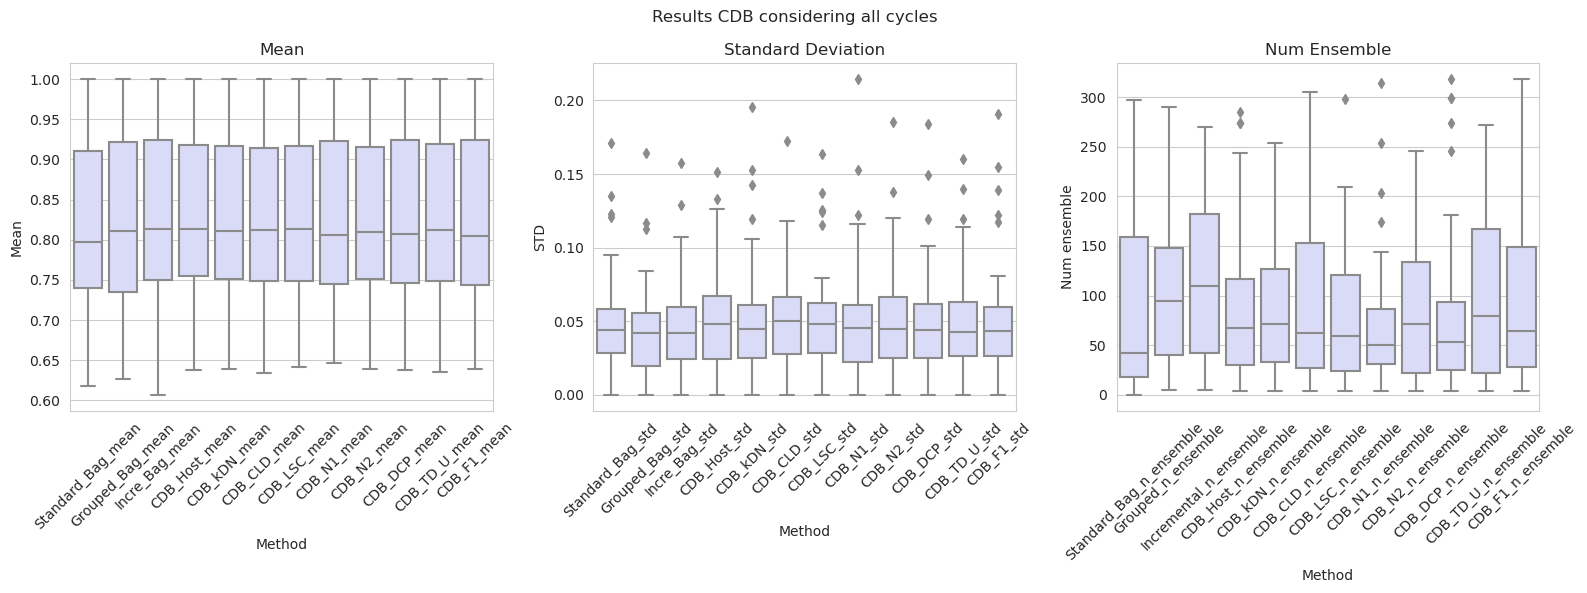

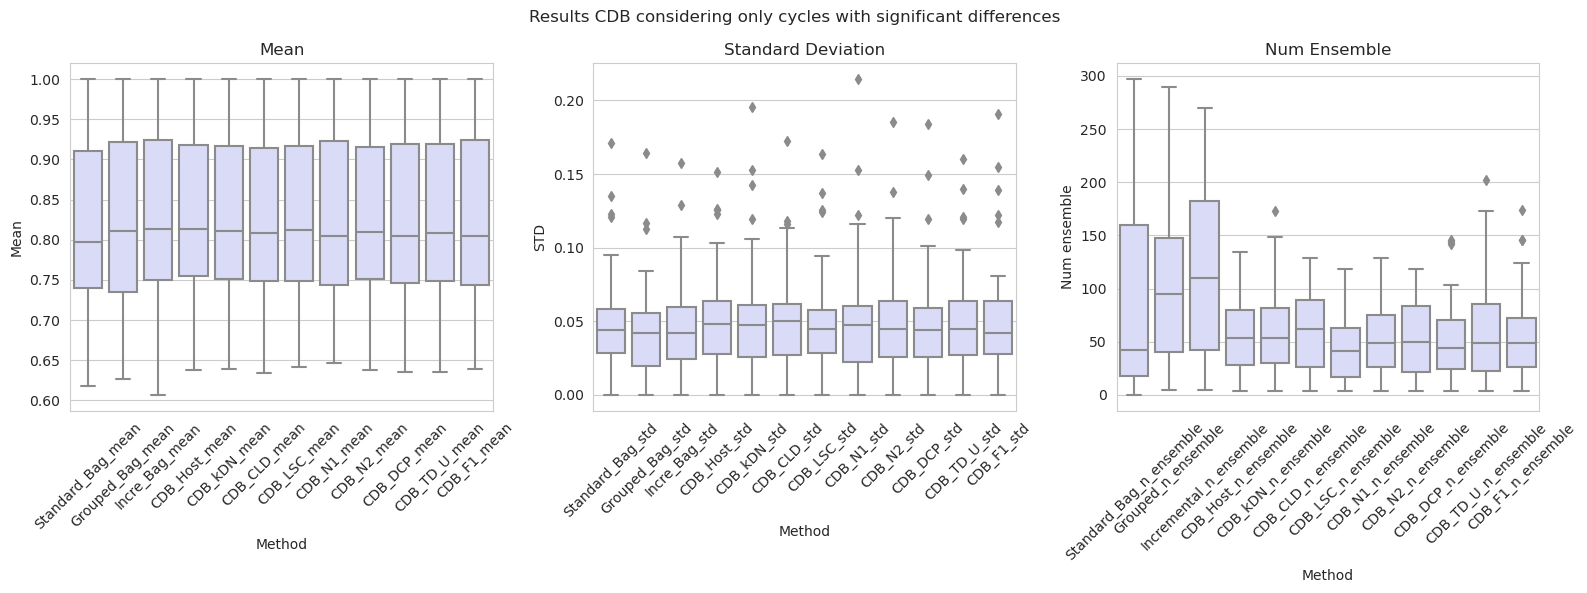

In [28]:

# Seleccionar datos para mean
mean_cols = ['Standard_Bag_mean',
       'Grouped_Bag_mean',  'Incre_Bag_mean',
       'CDB_Host_mean',  'CDB_kDN_mean', 'CDB_CLD_mean',
             'CDB_LSC_mean', 'CDB_N1_mean',
       'CDB_N2_mean',  'CDB_DCP_mean','CDB_TD_U_mean',
             'CDB_F1_mean']
mean_data = table_comparison[mean_cols]


# Reestructurar los datos para cada métrica
mean_data = table_comparison[[col for col in table_comparison.columns if '_mean' in col]].melt(var_name='Method', value_name='Mean')
std_data = table_comparison[[col for col in table_comparison.columns if '_std' in col]].melt(var_name='Method', value_name='STD')
ensemble_data = table_comparison[[col for col in table_comparison.columns if '_n_ensemble' in col]].melt(var_name='Method', value_name='Num ensemble')


fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=False)

sns.boxplot(ax=axes[0], x='Method', y='Mean', data=mean_data, color='#D4D7FC')
axes[0].set_title('Mean')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1], x='Method', y='STD', data=std_data, color='#D4D7FC')
axes[1].set_title('Standard Deviation')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[2], x='Method', y='Num ensemble', data=ensemble_data, color='#D4D7FC')
axes[2].set_title('Num Ensemble')
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle('Results CDB considering all cycles')
plt.tight_layout()
plt.show()





# Seleccionar datos para mean
mean_cols = ['Standard_Bag_mean',
       'Grouped_Bag_mean',  'Incre_Bag_mean',
       'CDB_Host_mean',  'CDB_kDN_mean', 'CDB_CLD_mean',
             'CDB_LSC_mean', 'CDB_N1_mean',
       'CDB_N2_mean',  'CDB_DCP_mean','CDB_TD_U_mean',
             'CDB_F1_mean']
mean_data_signif = table_comparison_signif[mean_cols]


# Reestructurar los datos para cada métrica
mean_data_signif = table_comparison_signif[[col for col in table_comparison_signif.columns if '_mean' in col]].melt(var_name='Method', value_name='Mean')
std_data_signif = table_comparison_signif[[col for col in table_comparison_signif.columns if '_std' in col]].melt(var_name='Method', value_name='STD')
ensemble_data_signif = table_comparison_signif[[col for col in table_comparison_signif.columns if '_n_ensemble' in col]].melt(var_name='Method', value_name='Num ensemble')



fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=False)

sns.boxplot(ax=axes[0], x='Method', y='Mean', data=mean_data_signif, color='#D4D7FC')
axes[0].set_title('Mean')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1], x='Method', y='STD', data=std_data_signif, color='#D4D7FC')
axes[1].set_title('Standard Deviation')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[2], x='Method', y='Num ensemble', data=ensemble_data_signif, color='#D4D7FC')
axes[2].set_title('Num Ensemble')
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle('Results CDB considering only cycles with significant differences')
plt.tight_layout()
plt.show()






#### Evolution graphs

For Standarg Bagging we plot all the results. For CDB we take the best accuracy result (only with significantly different cycles), we select that alpha-split combo and we plot all the cycles. For Mixed Bagging, we plot all the result. Notice that, for Mixed Bagging, every point plotted is a whole execution of the method, they are not "connected". Their result for 50 ensembles is their best result for 50 ensemble, their result for 45 ensembles is their best result for 45 ensemble and the final parameters can be totally different.

In [40]:
import warnings

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [42]:
def plot_evolution(best_param_cdb_signif,CM,df_cdb_signif,df_standard,df_mixed):
    list_datasets = best_param_cdb_signif.Dataset.unique()
    df_mixed.rename(columns={'n_trees': 'n_ensemble'}, inplace=True)

    n_datasets = len(list_datasets)
    n_cols = 3
    n_rows = -(-n_datasets // n_cols)  # Redondeo hacia arriba para obtener las filas necesarias

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), constrained_layout=True)

    axes = axes.flatten()

    for i, dataset_i in enumerate(list_datasets):
        ax = axes[i]
        #print(dataset_i)

        values = best_param_cdb_signif.loc[
            (best_param_cdb_signif['Dataset'] == dataset_i) & (best_param_cdb_signif['weights'] == CM),
            ['alpha', 'split']
        ]
        alpha = values.iloc[0]['alpha']
        split = values.iloc[0]['split']

        df_cdb_signif_plot = df_cdb_signif.loc[
                         (df_cdb_signif['Dataset'] == dataset_i) &
                         (df_cdb_signif['weights'] == CM) &
                         (df_cdb_signif['alpha'] == alpha) &
                         (df_cdb_signif['split'] == split), :
                         ]
        df_cdb_signif_plot = df_cdb_signif_plot.copy()

        df_cdb_plot = df_cdb_f.loc[
                  (df_cdb_f['Dataset'] == dataset_i) &
                  (df_cdb_f['weights'] == CM) &
                  (df_cdb_f['alpha'] == alpha) &
                  (df_cdb_f['split'] == split), :
                  ]

        # df_cdb_signif_plot['model'] = 'CDB_' + CM
        df_cdb_signif_plot.loc[:, 'model'] = 'CDB_' + CM
        df_cdb_plot.loc[:, 'model'] = 'CCDB'
        df_standard_plot = df_standard.loc[(df_standard['Dataset'] == dataset_i), :]
        df_standard_plot.loc[:, 'model'] = 'StandardBagg'
        df_mixed_plot = df_mixed.loc[(df_mixed['Dataset'] == dataset_i), :]

        df_plot = pd.concat([df_cdb_plot, df_cdb_signif_plot, df_standard_plot, df_mixed_plot])
        df_plot = df_plot[['n_ensemble', 'accuracy_mean', 'model']]  # Solo mantener las columnas relevantes

        for method, group in df_plot.groupby('model'):
            ax.plot(group['n_ensemble'], group['accuracy_mean'], marker='o', label=method)

        ax.set_title(f'{dataset_i}', fontsize=12)
        ax.set_xlabel('n_ensemble', fontsize=10)
        ax.set_ylabel('accuracy_mean', fontsize=10)
        ax.legend(title='Method', fontsize=8)
        ax.grid(alpha=0.3)

    # Si hay más subgráficos que datasets, eliminar los vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()
    return 

In [50]:
def plot_evolution_str(best_param_cdb_signif,CM,df_cdb_signif,df_standard,df_mixed):
    list_datasets = best_param_cdb_signif.Dataset.unique()
    df_mixed.rename(columns={'n_trees': 'n_ensemble'}, inplace=True)

    n_datasets = len(list_datasets)
    n_cols = 3
    n_rows = -(-n_datasets // n_cols)  # Redondeo hacia arriba para obtener las filas necesarias

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), constrained_layout=True)

    axes = axes.flatten()

    for i, dataset_i in enumerate(list_datasets):
        ax = axes[i]
        #print(dataset_i)

        values = best_param_cdb_signif.loc[
            (best_param_cdb_signif['Dataset'] == dataset_i) & (best_param_cdb_signif['weights'] == CM),
            ['alpha', 'split']
        ]
        alpha = values.iloc[0]['alpha']
        split = values.iloc[0]['split']

        df_cdb_signif_plot = df_cdb_signif.loc[
                         (df_cdb_signif['Dataset'] == dataset_i) &
                         (df_cdb_signif['weights'] == CM) &
                         (df_cdb_signif['alpha'] == str(alpha)) &
                         (df_cdb_signif['split'] == str(split)), :
                         ]
        df_cdb_signif_plot = df_cdb_signif_plot.copy()

        df_cdb_plot = df_cdb_f.loc[
                  (df_cdb_f['Dataset'] == dataset_i) &
                  (df_cdb_f['weights'] == CM) &
                  (df_cdb_f['alpha'] == str(alpha)) &
                  (df_cdb_f['split'] == str(split)), :
                  ]

        # df_cdb_signif_plot['model'] = 'CDB_' + CM
        df_cdb_signif_plot.loc[:, 'model'] = 'CDB_' + CM
        df_cdb_plot.loc[:, 'model'] = 'CCDB'
        df_standard_plot = df_standard.loc[(df_standard['Dataset'] == dataset_i), :]
        df_standard_plot.loc[:, 'model'] = 'StandardBagg'
        df_mixed_plot = df_mixed.loc[(df_mixed['Dataset'] == dataset_i), :]

        df_plot = pd.concat([df_cdb_plot, df_cdb_signif_plot, df_standard_plot, df_mixed_plot])
        df_plot = df_plot[['n_ensemble', 'accuracy_mean', 'model']]  # Solo mantener las columnas relevantes

        for method, group in df_plot.groupby('model'):
            ax.plot(group['n_ensemble'], group['accuracy_mean'], marker='o', label=method)

        ax.set_title(f'{dataset_i}', fontsize=12)
        ax.set_xlabel('n_ensemble', fontsize=10)
        ax.set_ylabel('accuracy_mean', fontsize=10)
        ax.legend(title='Method', fontsize=8)
        ax.grid(alpha=0.3)

    # Si hay más subgráficos que datasets, eliminar los vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()
    return 

In all these graphs note that the comparison is not fair because, for every point, we are plotting the best result for Mixed Bagging. We are not plotting that for our proposal.

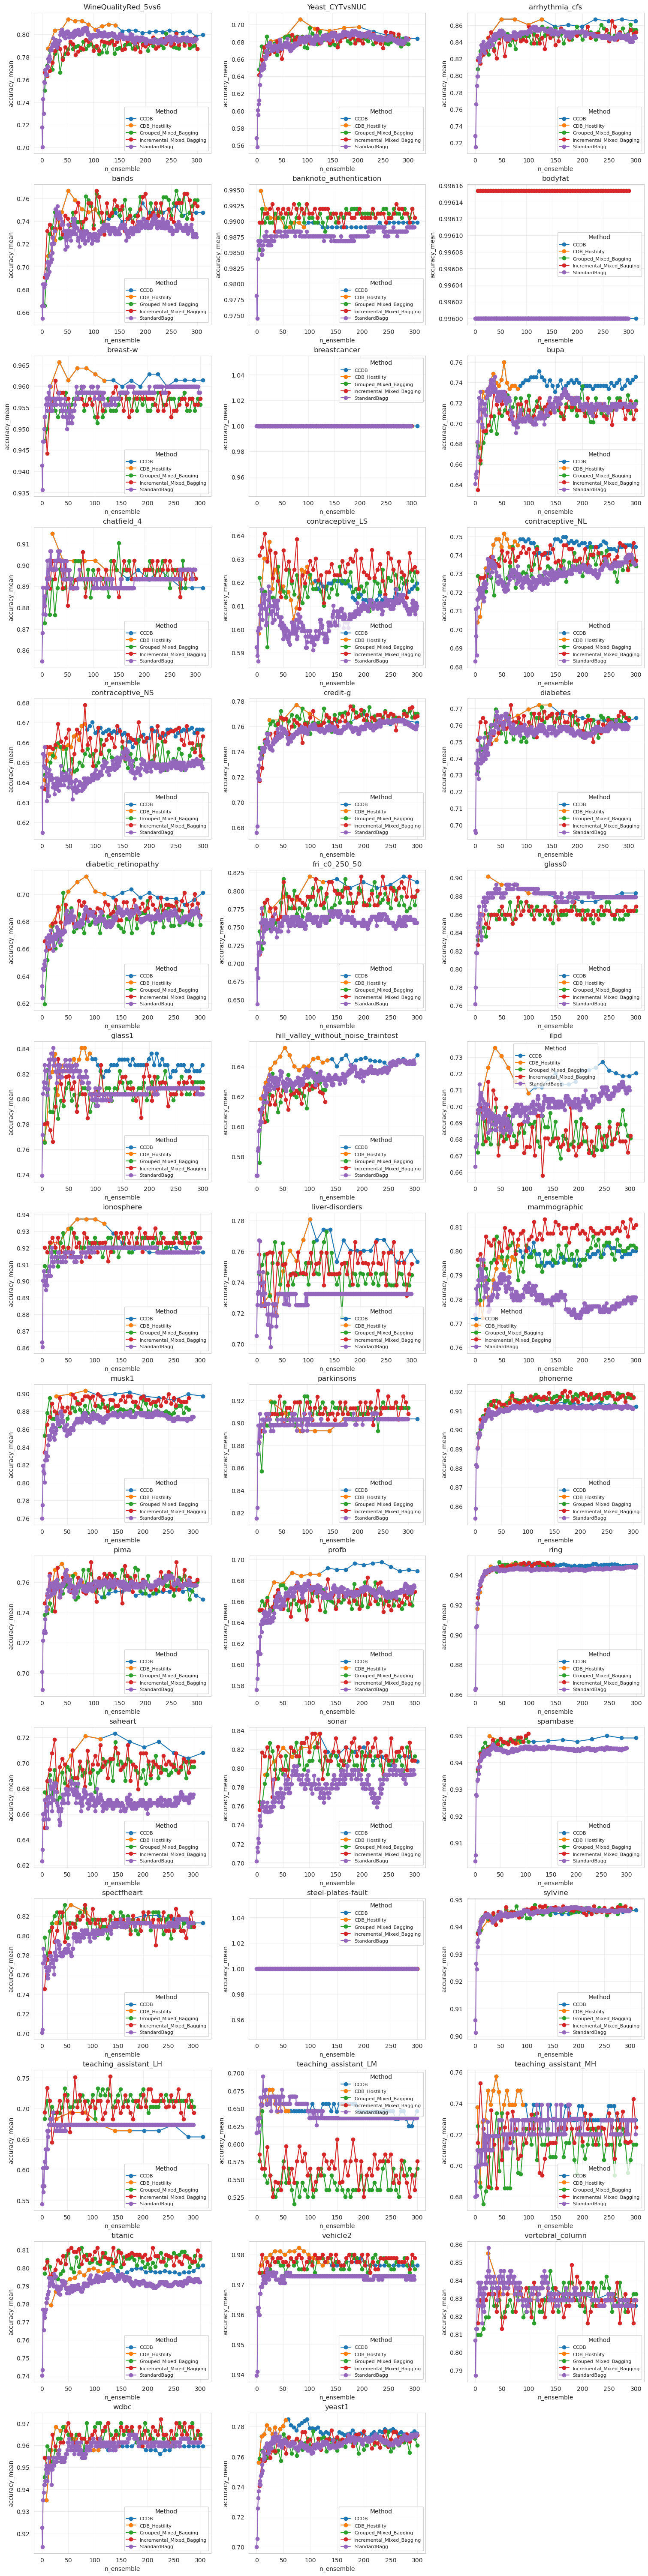

In [43]:
CM = 'Hostility'
plot_evolution(best_param_cdb_signif,CM,df_cdb_signif,df_standard,df_mixed)

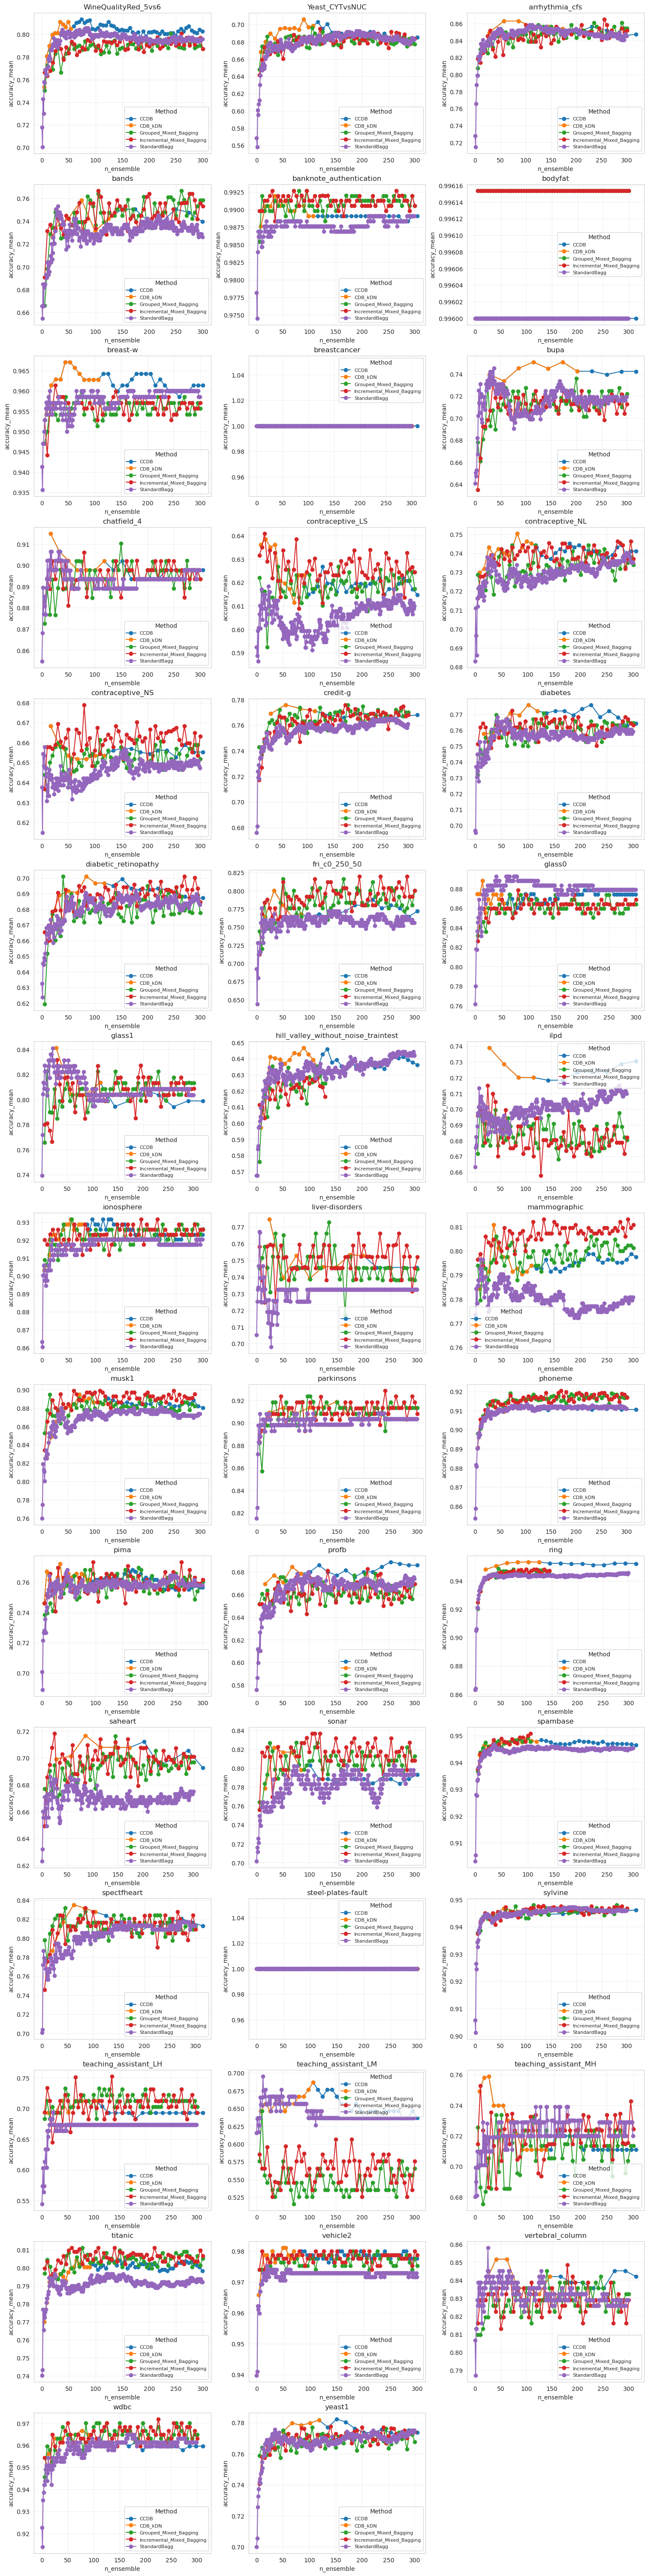

In [44]:
CM = 'kDN'
plot_evolution(best_param_cdb_signif,CM,df_cdb_signif,df_standard,df_mixed)

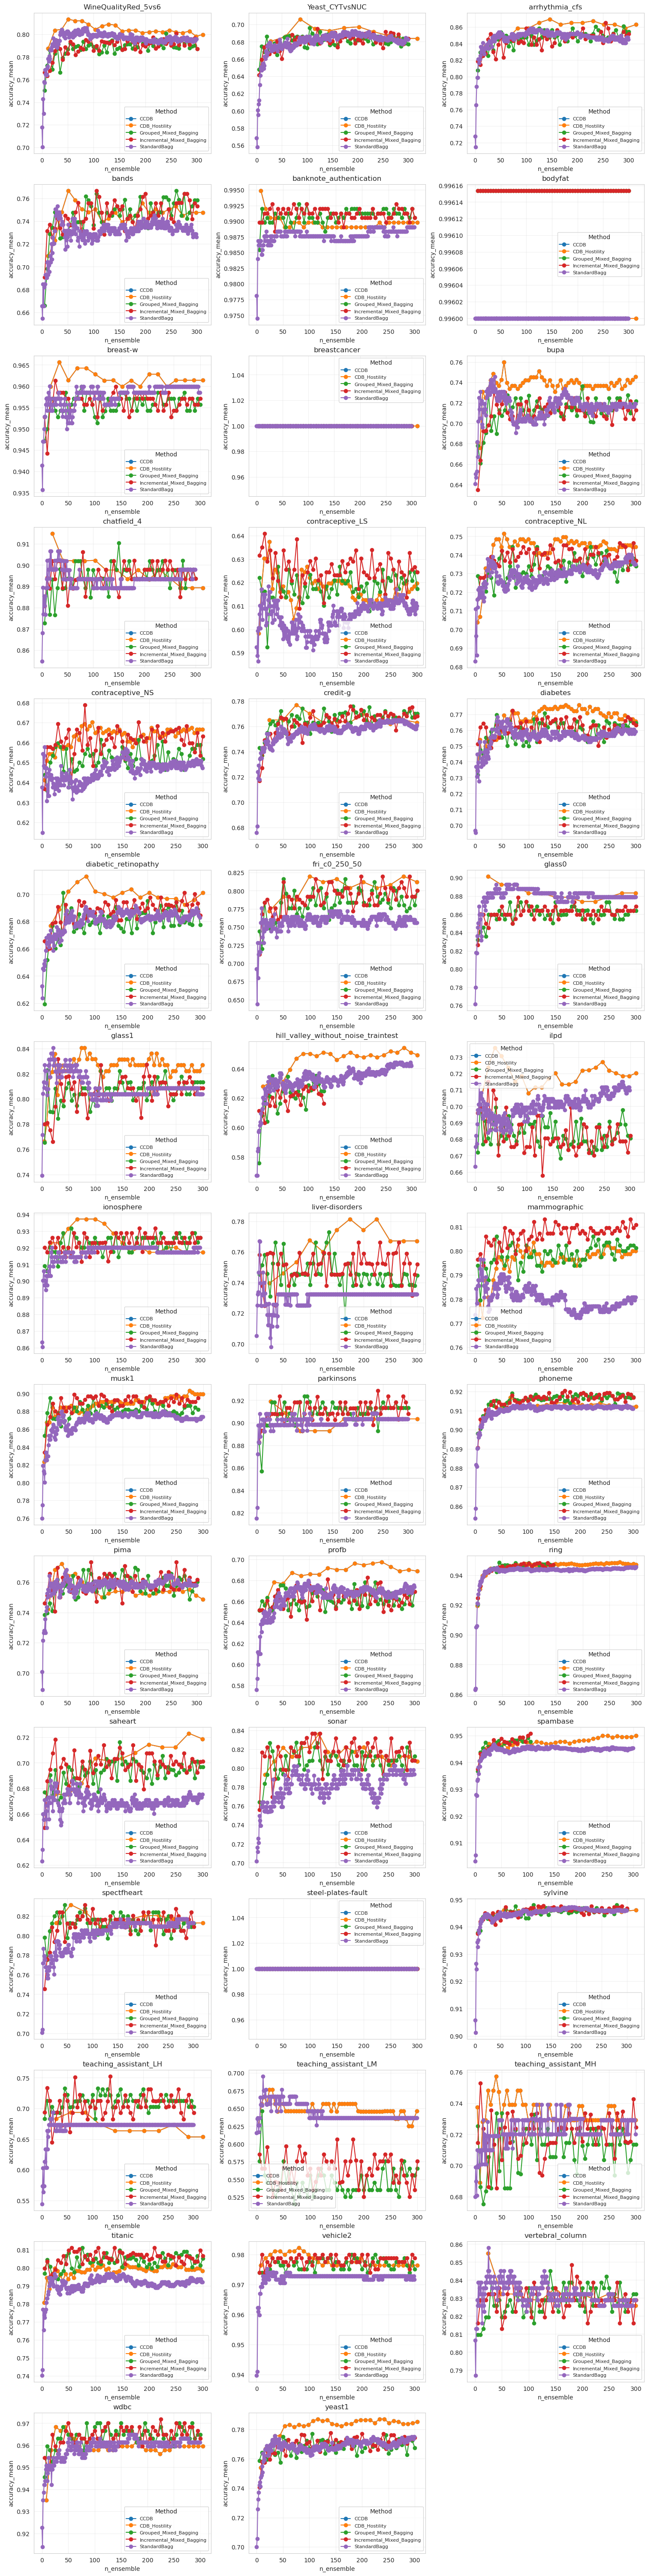

In [51]:
CM = 'Hostility'
plot_evolution_str(best_param_cdb,CM,df_cdb_f,df_standard,df_mixed)